#  Masking Pipeline

In [2]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask)
from chxanalys.chx_generic_functions import (get_detector, get_fields,  get_sid_filenames,load_data,  RemoveHot, show_img,get_avg_img, reverse_updown,create_cross_mask )
from skimage.draw import line_aa, line, polygon, circle
 
%matplotlib notebook

# Path for Saving Results

In [3]:
CYCLE= '2016_3'

In [4]:
path = '/XF11ID/analysis/%s/masks/'%CYCLE
print ("The analysis results will be saved in : %s"%path)

The analysis results will be saved in : /XF11ID/analysis/2016_3/masks/


### Get the image series and metadata from the uid

In [6]:
uid = '129ecb'

In [7]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  11002--129ecb9d-8757-4460-9a6b-0669ca87ccdb--/XF11ID/data/2016/12/03/46d54be9-2c29-4be9-aa2f_3568


In [8]:
#imgs = load_data( uid, detector, reverse= True  )
imgs = load_data( uid, detector, reverse= False  )
md = imgs.md
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2016/12/03/46d54be9-2c29-4be9-aa2f_3568_master.h5


In [9]:
imgs

<Frames>
Length: 1 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

In [10]:
md

{'beam_center_x': 1443.0,
 'beam_center_y': 816.0,
 'count_time': 0.099990003,
 'detector_distance': 4.8899999,
 'frame_time': 0.1,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [12]:
 pixel_mask =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

## show image and the pixel mask

* show image

<IPython.core.display.Javascript object>


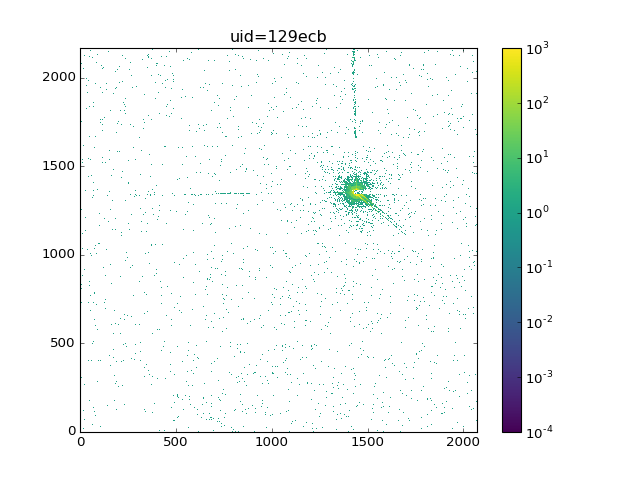

In [14]:
show_img(  imgs[0]*pixel_mask , vmin=.0001, vmax=1000, logs=True, image_name ='uid=%s'%uid )

* pixel mask

<IPython.core.display.Javascript object>


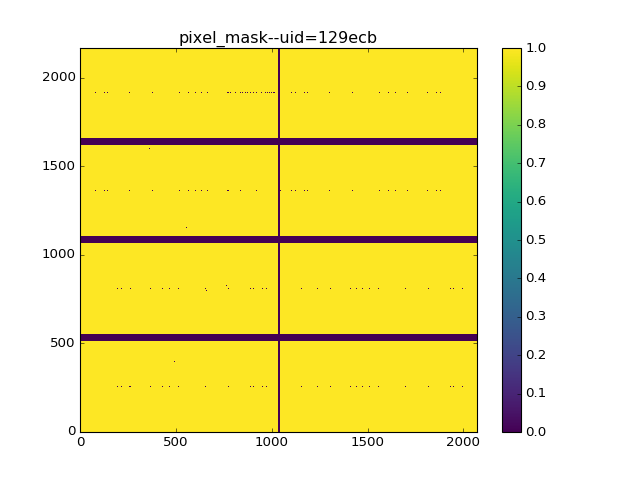

In [15]:
show_img(pixel_mask, vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid )

## Remove hotspots in the image

In [16]:
avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = False, uid =uid)

<IPython.core.display.Javascript object>


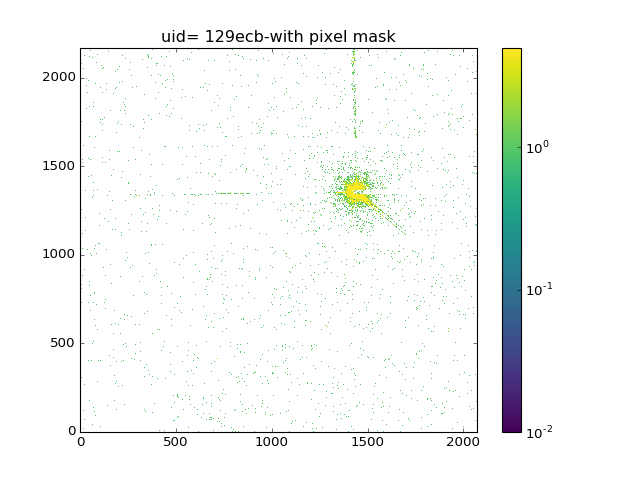

In [19]:
show_img(avg_img*pixel_mask,vmin=0.01,vmax=5, logs=True, image_name= 'uid= %s with pixel mask'%uid)

<IPython.core.display.Javascript object>


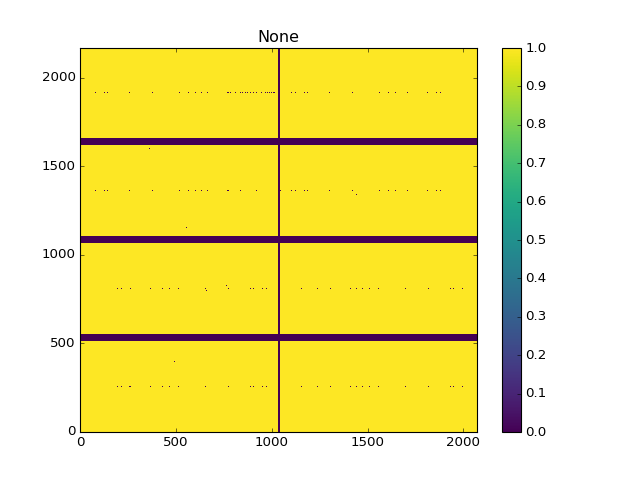

In [20]:
mask_rh  = RemoveHot( avg_img, 5E8, plot_=True)

# Create a polygon mask

* check beam center

In [21]:
#md['beam_center_x']=1437;md['beam_center_y']=824
md['beam_center_x'],2167-md['beam_center_y']

(1443.0, 1351.0)

### To create multi-rectangle masks, for each sub-mask



In [22]:
#creat the left part mask
partial_mask = create_cross_mask(  avg_img, center=[ 1413, 1350],
                            wy_left=0, wy_right= 16, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )

In [23]:
#creat the right part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 1436.0, 1348.0],
                            wy_left=12, wy_right= 12, 
                              wx_up= 12, wx_down= 12,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [24]:
#creat the up part mask
partial_mask  *= create_cross_mask(  avg_img, center=[ 1440, 1351],
                            wy_left=0, wy_right= 0, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )

In [25]:
#creat the down part mask
partial_mask *= create_cross_mask(  avg_img, center=[ 1444, 1351],
                            wy_left=0, wy_right= 0, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )

In [26]:
full_mask = partial_mask

<IPython.core.display.Javascript object>


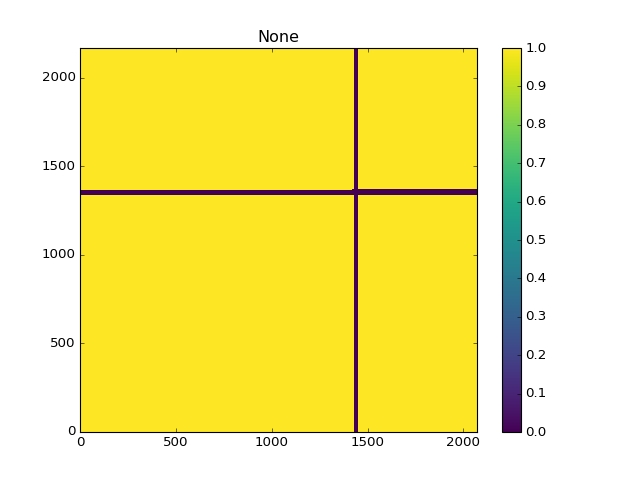

In [27]:
show_img( full_mask  )

In [28]:
mask = np.array ( full_mask * pixel_mask*mask_rh  , dtype = bool )

<IPython.core.display.Javascript object>


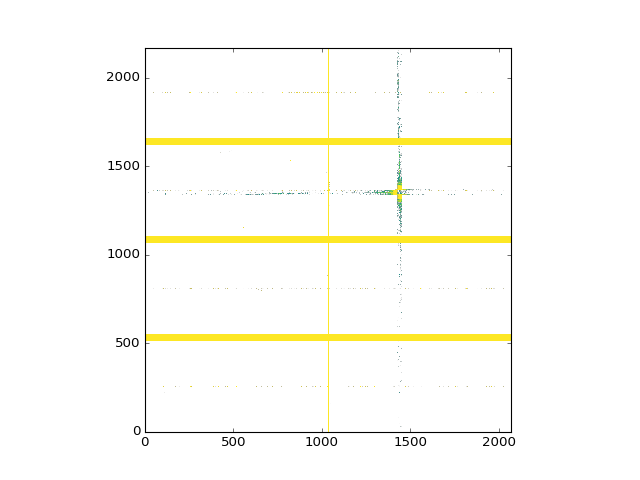

In [29]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.1, vmax= 1e1 ), cmap='viridis')
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


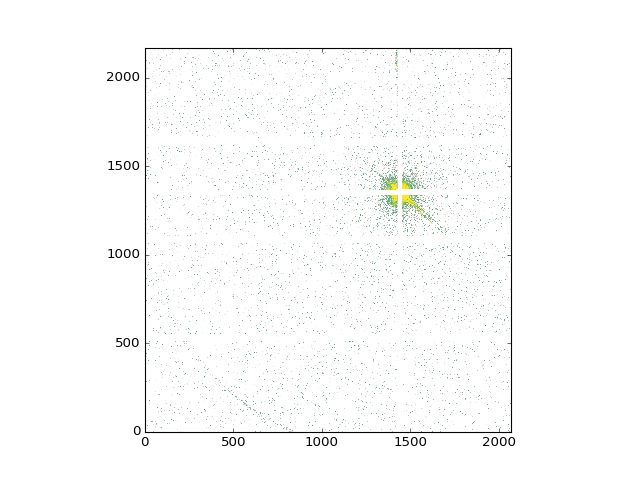

In [30]:
fig, ax = plt.subplots()
im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=.1, vmax=3 ) )
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


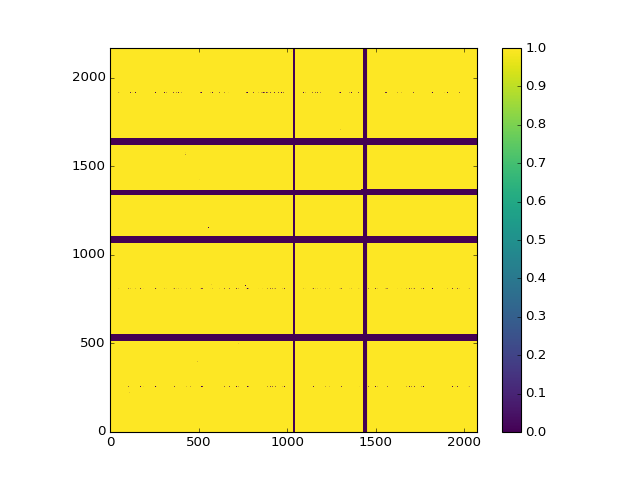

In [31]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [32]:
np.save(  path +   uid +"_mask", mask)

In [33]:
path +   uid +"_mask"

'/XF11ID/analysis/2016_3/masks/129ecb_mask'

In [35]:
meaningful_name = 'Dec3_4M_SAXS2' +"_mask"

In [ ]:
np.save(  path +   meaningful_name, mask)